In [1]:
library(miloR)
library(SingleCellExperiment)
library(scater)
library(dplyr)
library(patchwork)
library(BiocParallel)
setwd('/lustre/scratch117/cellgen/team297/kt16/Ziad/scanpy')

Loading required package: edgeR

Loading required package: limma

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedi

In [2]:
mylox1 <- readRDS('h5ad/R/milo_classical_mono_1.5.RDS')
mylox2 <- readRDS('h5ad/R/milo_classical_mono_2.5.RDS')

In [3]:
da.res_1.5 <- readRDS(file = 'h5ad/R/model_1/milo_results_1.5vsuntreated_classical_mono.RDS')
da.res_2.5 <- readRDS(file = 'h5ad/R/model_1/milo_results_2.5vsuntreated_classical_mono.RDS')

In [4]:
da.res_1.5 <- annotateNhoods(mylox1, da.res_1.5, coldata_col = "leiden_mono")
da.res_1.5$leiden_mono <- ifelse(da.res_1.5$leiden_mono_fraction < 0.7, "Mixed", da.res_1.5$leiden_mono)
da.res_2.5 <- annotateNhoods(mylox2, da.res_2.5, coldata_col = "leiden_mono")
da.res_2.5$leiden_mono <- ifelse(da.res_2.5$leiden_mono_fraction < 0.7, "Mixed", da.res_2.5$leiden_mono)

In [5]:
library(ggbeeswarm)
library(ggplot2)
new_DA_beeswarm_split <- function (da.res1, da.res2, max = 5, group.by = NULL, split.by =NULL, alpha = 0.1, subset.nhoods = NULL, size = 2, filter = c('Mixed', 'doublets')) 
{
    da.res1$split = split.by[1]
    da.res2$split = split.by[2]
    da.res <- rbind(da.res1, da.res2)
    da.res$beta[da.res$beta > max] <- max
    da.res$beta[da.res$beta < -max] <- -max
    da.res <- da.res %>% filter(!get(group.by) %in% filter)
    if (!is.null(group.by)) {
        if (!group.by %in% colnames(da.res)) {
            stop(paste0(group.by, " is not a column in da.res. Have you forgot to run annotateNhoods(x, da.res, ", 
                group.by, ")?"))
        }
        if (is.numeric(da.res[, group.by])) {
            stop(paste0(group.by, " is a numeric variable. Please bin to use for grouping."))
        }
        da.res <- mutate(da.res, group_by = da.res[, group.by])
    }
    else {
        da.res <- mutate(da.res, group_by = "g1")
    }    
    if (!is.factor(da.res[, "group_by"])) {
        message(paste0("Converting group.by to factor..."))
        da.res <- mutate(da.res, factor(group_by, levels = unique(group_by)))
    }
    if (!is.null(subset.nhoods)) {
        da.res <- da.res[subset.nhoods, ]
    }
        
    da.res <- da.res %>% mutate(is_signif = ifelse(SpatialFDR < alpha, 
        1, 0)) %>% mutate(beta_color = ifelse(is_signif == 1, 
        beta, NA)) %>% arrange(group_by) %>% mutate(Nhood = factor(Nhood, 
        levels = unique(Nhood)))
    p <- ggplot(da.res, aes(group_by, beta, color = beta_color)) + 
        scale_color_gradient2(midpoint = 0, low = "#0571b0", mid = '#f7f7f7', high = "#ca0020", limits=c(-max/3, max/3), oob=scales::squish) +
        guides(color = "none") + 
        xlab(group.by) + 
        ylab("beta") + 
        geom_quasirandom(alpha = 1, size = size) +
        coord_flip() + 
        theme_bw() + 
        theme(axis.title.y = element_blank(),
              axis.title.x = element_text(size=20, color = '#000000'),
              axis.text = element_text(size=20, color = '#000000'),
              axis.ticks = element_line(color = '#000000'),
              panel.border = element_rect(colour = "#000000")
            ) + 
        facet_wrap(split~.) +
        theme(strip.background = element_blank(), strip.text.x = element_text(angle = 0, size = 20, color = '#000000'))
    p$data <- p$data[order(p$data$beta_color, na.last = FALSE), ]
    return(p)
}

Converting group.by to factor...



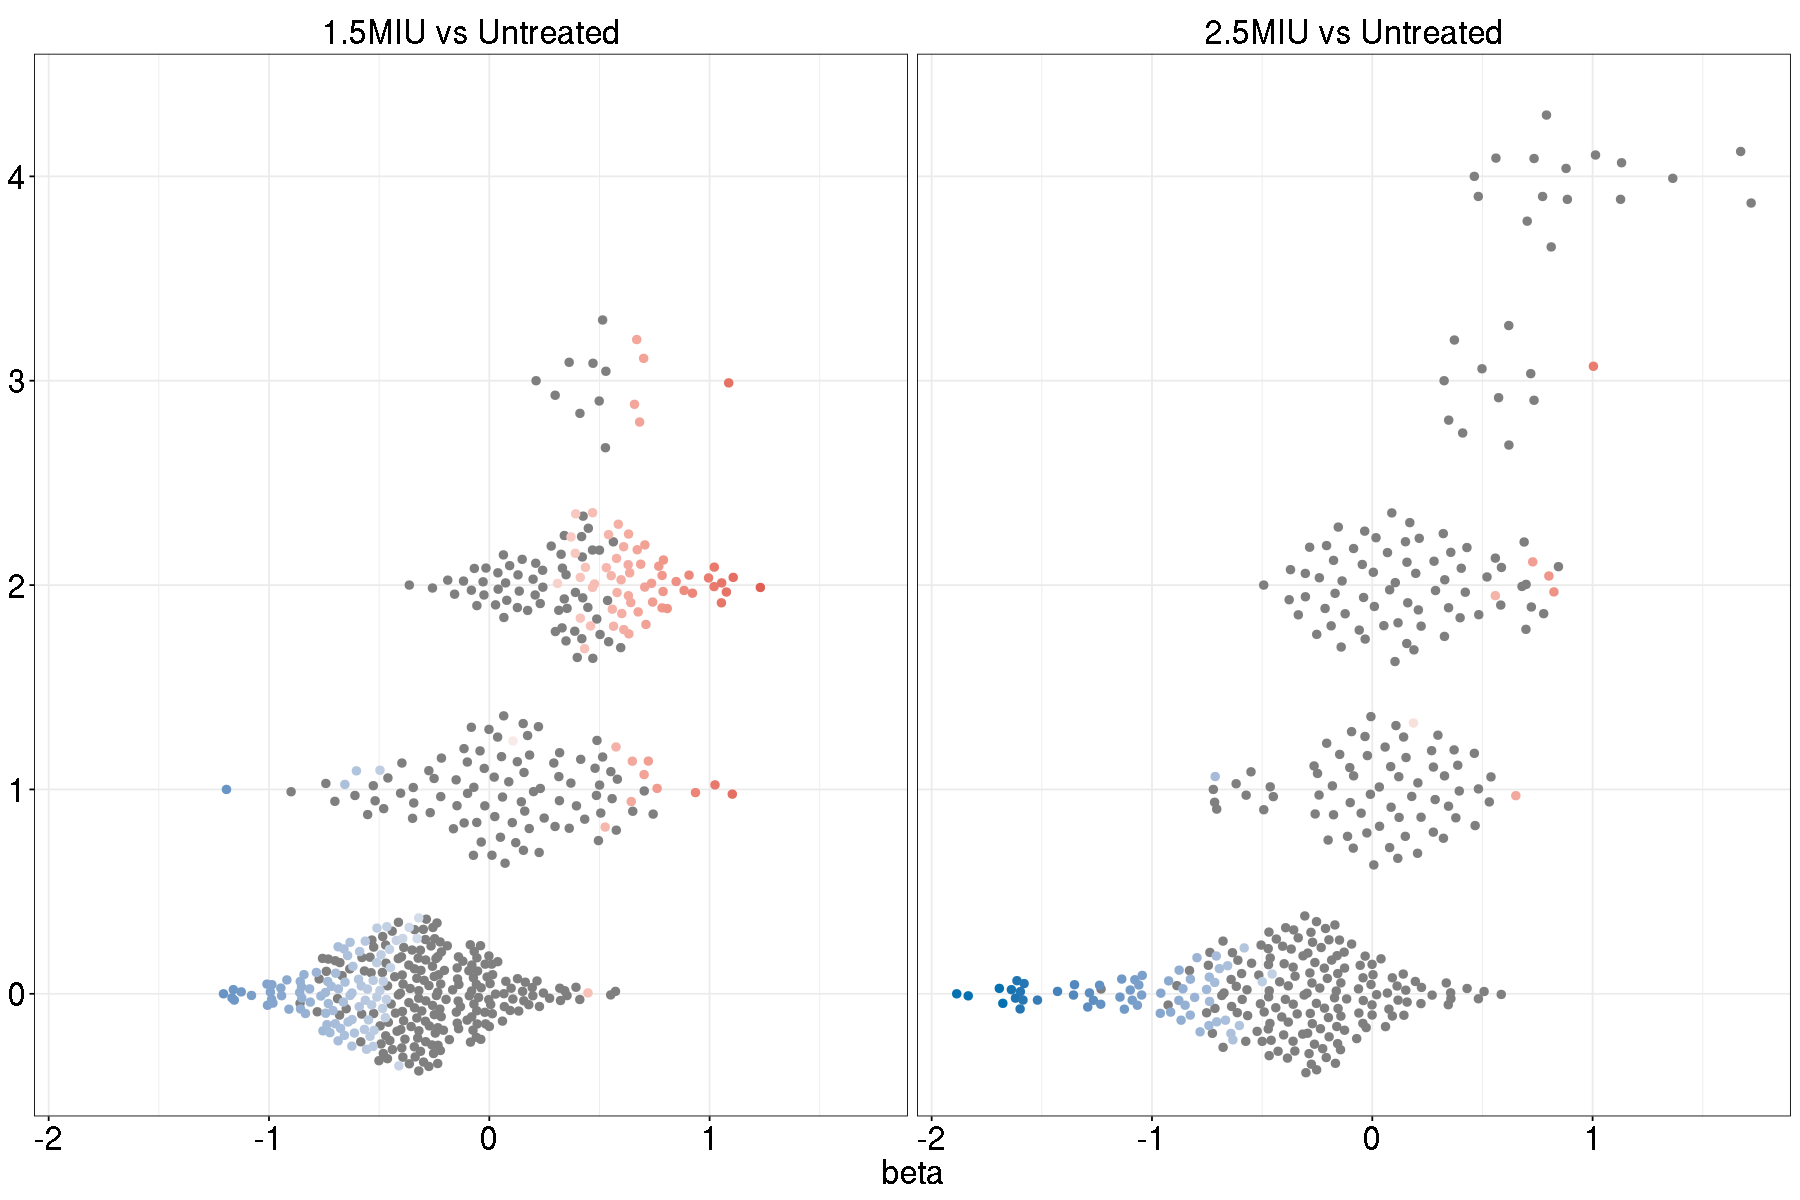

In [6]:
options(repr.plot.width=15, repr.plot.height=10)
p <- new_DA_beeswarm_split(da.res_1.5, da.res_2.5, group.by = "leiden_mono", split.by = c('1.5MIU vs Untreated', '2.5MIU vs Untreated'), size = 2)
p